In [238]:
%matplotlib inline
import io
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Javascript, display, HTML, Markdown as md
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import json
import requests
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [239]:
banks = {
        'DBS': {
                'ticker': 'D05',
                'morningstarID': '0P0000A67J'
        },
        'OCBC':  {
                'ticker': 'O39',
                'morningstarID': '0P0000A68H'
        },
        'UOB':{
                'ticker': 'U11',
                'morningstarID': '0P0000A692'
        }
}

dict_keys(['DBS', 'OCBC', 'UOB'])


In [240]:
dropdown = widgets.Dropdown(options = sorted(banks.keys()))
chosen = 'DBS'

def dropdown_eventhandler(change):
    global chosen 
    chosen = change.new
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
    
dropdown.observe(dropdown_eventhandler, names='value')

display(dropdown)


Dropdown(options=('DBS', 'OCBC', 'UOB'), value='DBS')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [310]:
finUrl = 'https://api-global.morningstar.com/sal-service/v1/stock/newfinancials/{id}/{report}/detail?dataType=A&reportType=A&locale=en&&operation=export&clientId=MDC&benchmarkId=category&version=3.21.1'
finHeaders = {
    'Referer': 'https://www.morningstar.com/', 
    'apikey': 'lstzFDEOhfFNMLikKa0am9mgEKLBl49T', 
    'x-sal-contenttype': 'nNsGdN3REOnPMlKDShOYjlk6VYiEVLSdpfpXAm7o2Tk='
}

keyRatioUrl = 'http://financials.morningstar.com/finan/ajax/exportKR2CSV.html?&callback=?&t=XSES:{ticker}&region=sgp&culture=en-US&cur=&order=asc'
keyRatioHeaders = {
    'Referer': 'http://financials.morningstar.com/ratios/r.html?t=D05&region=sgp&culture=en-US'
}

def cleanData(df, roundDown = True):
     # Remove whitespaces
    df.index = df.index.str.strip()
    # Transpose df to make metrics as columns
    df = df.T
    # Remove commas and convert str to float for all cols
    df[df.keys()] = df[df.keys()].replace({',': ''}, regex=True).astype(float)
    df = df/1000000 if roundDown else df
    # Reorder the rows to be ascending downwards
    df = df.sort_index()
    return df

def cleanKeyRatios(df):
    df = df.fillna(0)
    # Get names of indexes for which column '2010-12 has value '2010-12' or empty rows
    indexNames = df[(df['2010-12'] == '2010-12') | (
                    (df['2011-12'] == 0) &
                    (df['2012-12'] == 0) &
                    (df['2013-12'] == 0) &
                    (df['2014-12'] == 0) &
                    (df['2015-12'] == 0) &
                    (df['2016-12'] == 0) &
                    (df['2017-12'] == 0) &
                    (df['2018-12'] == 0) &
                    (df['2019-12'] == 0) &
                    (df['TTM'] == 0) 
                    )].index
    df = df.drop(indexNames , inplace=False)
    df = df.rename(columns={'2010-12': '2010',
                       '2011-12': '2011',
                       '2012-12': '2012',
                       '2013-12': '2013',
                       '2014-12': '2014',
                       '2015-12': '2015',
                       '2016-12': '2016',
                       '2017-12': '2017',
                       '2018-12': '2018',
                       '2019-12': '2019',
                       'TTM': 'TTM/Latest Quarter',
                      })
    
    return cleanData(df, False)
    


# Download finacial reports and clean up the data
reports = {
    'balancesheet': None,
    'incomestatement': None,
    'cashflow': None,
}
for types in reports.keys():
    print('Downloading % s'%types)
    response = requests.get(finUrl.format(id = banks[chosen]['morningstarID'], report = types), headers=finHeaders)
    with io.BytesIO(response.content) as fh:
        reports[types] = cleanData(pd.io.excel.read_excel(fh, index_col=0))
    print('Done')

        
# Download key ratio data
print('Downloading Key Ratios data')
with open('keyratios.csv', 'wb') as f:
    response = requests.get(keyRatioUrl.format(ticker = banks[chosen]['ticker']), headers=keyRatioHeaders)
    f.write(response.content)

keyratios = pd.read_csv('keyratios.csv', index_col=0, skiprows=2, header=0, na_values = '', skip_blank_lines=False )
keyratios = cleanKeyRatios(keyratios)
keyratios.to_csv('clean_keyratios.csv')

print('Done')


Done
Done
Done
Done


## Revenue VS Net Income 

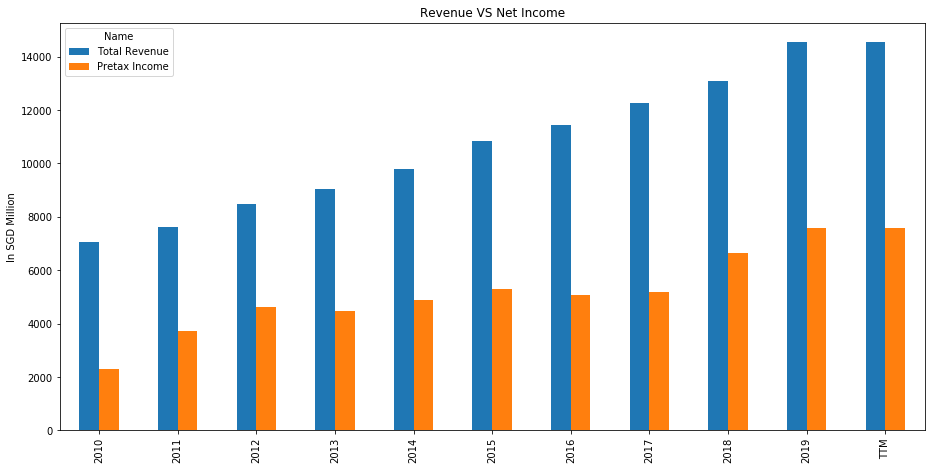

In [311]:
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(15.5, 7.5)

reports["incomestatement"][['Total Revenue', 'Pretax Income']].plot.bar(ax=axs)
axs.set_title('Revenue VS Net Income');
axs.set_ylabel("In SGD Million");

## Efficiency Ratio for Banks

(Operating Expenses)/(Total Revenue)

Note that Operating Expenses does not include Interest Expenses, as the latter is naturally occurring when the deposits within a bank grow. However, Non-Interest Expenses, such as marketing or operational expenses, can be controlled by the bank. 
A bank efficiency ratio measures a bank's overhead as a percentage of its revenue. A lower efficiency ratio means that a bank is operating better. An efficiency ratio of 50% or under is considered optimal. If the efficiency ratio increases, it means a bank's expenses are increasing or its revenues are decreasing.


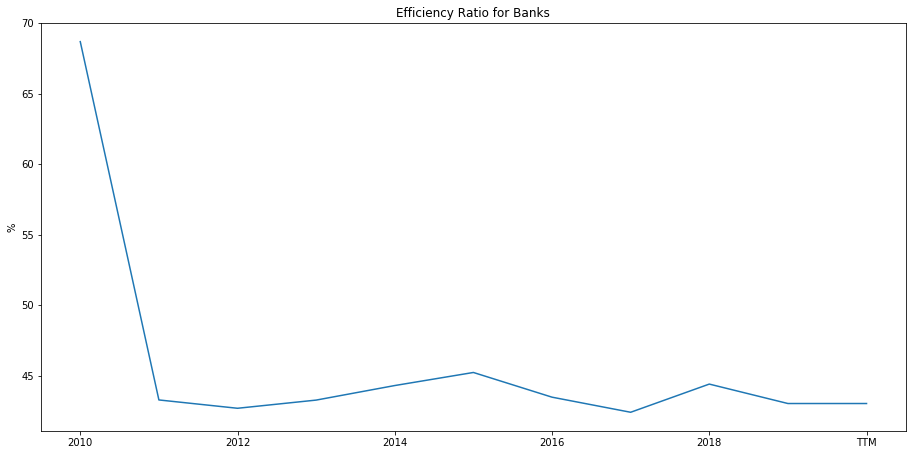

In [312]:
effiencyRatio = (reports["incomestatement"]['Non-Interest Expenses'].abs()/reports["incomestatement"]['Total Revenue'])*100
                                                                                                 
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(15.5, 7.5)

effiencyRatio.plot()
axs.set_title('Efficiency Ratio for Banks');
axs.set_ylabel("%");                                                                                                 

## Net Interest Margin

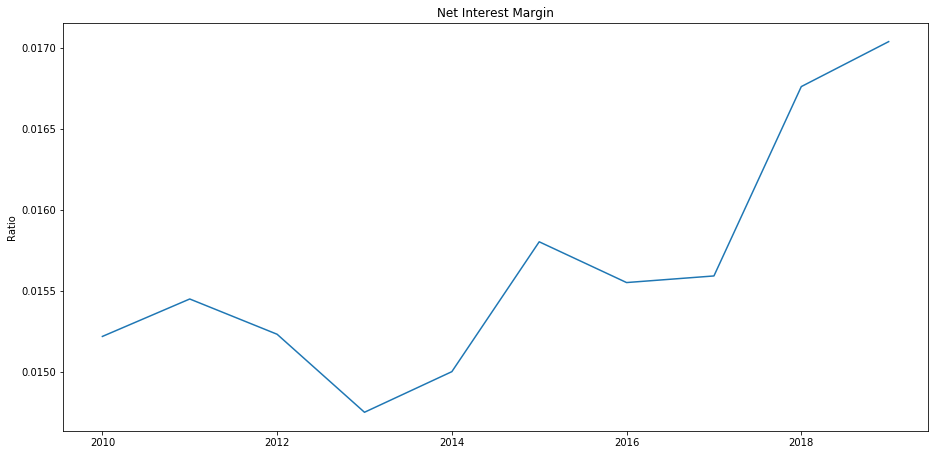

In [313]:
assets = reports['balancesheet']['Total Assets']
assets.head(10)
avgAssets = pd.Series([], dtype='float64')

for i in range(assets.shape[0]):
    if i == 0: 
        avgAssets[assets.index[i]] = (assets[i] + assets[0])/2 
    else: 
        avgAssets[assets.index[i]] = (assets[i] + assets[i-1])/2
netInteretMargin = reports['incomestatement']['Net Interest Income'] / avgAssets

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(15.5, 7.5)

netInteretMargin.plot()
axs.set_title('Net Interest Margin');
axs.set_ylabel("Ratio");  

In [314]:
avgAssets

2010   283710.000
2011   312278.500
2012   346940.000
2013   377520.500
2014   421337.000
2015   449250.000
2016   469702.000
2017   499640.500
2018   534231.000
2019   564848.500
dtype: float64

In [315]:
assets.shape[0]

10

## Operating Leverage

In [316]:
# reports['balancesheet']

In [317]:
# reports['incomestatement']

In [318]:
# reports['cashflow']

In [319]:
# keyRatios

In [320]:
for i in range(4):
    print(i)

0
1
2
3
